# Multi-Class Deep Learning Model for Rock Paper Scissors Using TensorFlow Take 2
### David Lowe
### September 1, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Rock Paper Scissors dataset is a multi-class classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: When learning Computer Vision, especially the training of DNNs and CNNs to recognize and classify images, there is a shortage of suitable datasets. Laurence Moroney wanted to fix that problem by creating a dataset that could be used for teaching multi-class classifiers that were unique and distinct from existing datasets. Laurence also wished to see if he could use Photo-real CGI to train a neural network that could then recognize and classify real images with the same subject matter.

The Rock Paper Scissors dataset contains images from a variety of different hand poses with different races, ages, and genders. These images have all been generated using CGI techniques as an experiment in determining if a CGI-based dataset can be used for classification against real photos. All of this data is posed against a white background, and each image is 300×300 pixels in 24-bit color.

From iteration Take1, we constructed and tuned machine learning models for this dataset using TensorFlow with two VGG blocks. Laurence also demonstrated the dataset using a model with four VGG blocks, each block with just one convolution layer. We also observed the best result that we could obtain using different VGG-2 models with a different number of convolution layers.

In this Take2 iteration, we will construct and tune machine learning models for this dataset using TensorFlow with three VGG blocks. Laurence also demonstrated the dataset using a model with four VGG blocks, each block with just one convolution layer. We will observe the best result that we could obtain using different VGG-3 models with a different number of convolution layers.

ANALYSIS: From iteration Take1, the performance of the baseline model achieved an accuracy score of 97.85% on the validation dataset after 15 epochs. After a series of modeling trials, the TensorFlow model with two VGG blocks and two convolution layers processed the validation dataset with an accuracy score of 95.16%.

In this Take2 iteration, the performance of the baseline model achieved an accuracy score of 100% on the validation dataset after 15 epochs. After a series of modeling trials, the TensorFlow model with three VGG blocks and two convolution layers processed the validation dataset with an accuracy score of 100%.

CONCLUSION: For this dataset, the model built using TensorFlow with three VGG blocks did not improve the result from the baseline model. However, we still should consider using TensorFlow and VGG blocks to model this dataset further.

Dataset Used: Rock Paper Scissors Dataset

Dataset ML Model: Multi-classification with numerical attributes

Dataset Reference: http://www.laurencemoroney.com/rock-paper-scissors-dataset/

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Data
3. Define and Train Model
4. Evaluate and Optimize Model
5. Finalize Model and Make Predictions

# Task 1. Prepare Environment

In [ ]:
# Install the packages to support accessing environment variable and SQL databases
!pip install python-dotenv PyMySQL

     |████████████████████████████████| 51kB 3.1MB/s 


In [ ]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Aug 23 01:16:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


In [ ]:
# Direct Colab to use TensorFlow v2
%tensorflow_version 2.x

In [ ]:
# Set the random seed number for reproducible results
seedNum = 888

In [ ]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import os
import sys
import zipfile
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from dotenv import load_dotenv
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Check the number of GPUs accessible through TensorFlow
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useGDrive = False
if useGDrive:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set various default Keras modeling parameters
default_loss = 'categorical_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.LecunUniform(seed=seedNum)
default_epoch = 15
default_batch = 64
default_image_size = (150, 150)
num_class = 3

# Define the labels to use for graphing the data
train_metric = "accuracy"
train_loss = "loss"

Num GPUs Available:  1


In [ ]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [ ]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [ ]:
if (notifyStatus): status_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 2. Load and Prepare Data

In [ ]:
if (notifyStatus): status_notify("Task 2. Load and Prepare Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [ ]:
!rm -rf image/
!rm rps.zip
!rm rps-test-set.zip

rm: cannot remove 'rps.zip': No such file or directory
rm: cannot remove 'rps-test-set.zip': No such file or directory


In [ ]:
image_dir = 'image/'
!mkdir image/

In [ ]:
!wget https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps.zip

--2020-08-23 01:17:04--  https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.224.8.32, 13.224.8.52, 13.224.8.76, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.224.8.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191.38M  17.9MB/s    in 11s     

2020-08-23 01:17:15 (17.8 MB/s) - ‘rps.zip’ saved [200682221/200682221]



In [ ]:
!wget https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps-test-set.zip

--2020-08-23 01:17:16--  https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps-test-set.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.224.8.76, 13.224.8.32, 13.224.8.52, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.224.8.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rps-test-set.zip’

rps-test-set.zip    100%[===================>]  28.15M  20.3MB/s    in 1.4s    

2020-08-23 01:17:17 (20.3 MB/s) - ‘rps-test-set.zip’ saved [29516758/29516758]



In [ ]:
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(image_dir)
local_zip = 'rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(image_dir)
zip_ref.close()

In [ ]:
train_rock_dir = os.path.join(image_dir, 'rps/rock')
train_paper_dir = os.path.join(image_dir, 'rps/paper')
train_scissors_dir = os.path.join(image_dir, 'rps/scissors')

print('total training rock images:', len(os.listdir(train_rock_dir)))
print('total training paper images:', len(os.listdir(train_paper_dir)))
print('total training scissors images:', len(os.listdir(train_scissors_dir)))

train_rock_files = os.listdir(train_rock_dir)
print(train_rock_files[:10])

train_paper_files = os.listdir(train_paper_dir)
print(train_paper_files[:10])

train_scissors_files = os.listdir(train_scissors_dir)
print(train_scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock01-079.png', 'rock04-030.png', 'rock06ck02-071.png', 'rock01-042.png', 'rock02-040.png', 'rock01-008.png', 'rock01-061.png', 'rock04-011.png', 'rock06ck02-065.png', 'rock07-k03-101.png']
['paper01-012.png', 'paper05-068.png', 'paper02-025.png', 'paper07-055.png', 'paper03-025.png', 'paper07-098.png', 'paper06-094.png', 'paper02-012.png', 'paper07-020.png', 'paper02-066.png']
['scissors04-031.png', 'scissors01-039.png', 'testscissors03-025.png', 'testscissors02-077.png', 'testscissors03-111.png', 'scissors01-013.png', 'testscissors03-103.png', 'testscissors03-073.png', 'testscissors01-089.png', 'scissors01-044.png']


In [ ]:
validation_rock_dir = os.path.join(image_dir, 'rps-test-set/rock')
validation_paper_dir = os.path.join(image_dir, 'rps-test-set/paper')
validation_scissors_dir = os.path.join(image_dir, 'rps-test-set/scissors')

print('total validation rock images:', len(os.listdir(validation_rock_dir)))
print('total validation paper images:', len(os.listdir(validation_paper_dir)))
print('total validation scissors images:', len(os.listdir(validation_scissors_dir)))

validation_rock_files = os.listdir(validation_rock_dir)
print(validation_rock_files[:10])

validation_paper_files = os.listdir(validation_paper_dir)
print(validation_paper_files[:10])

validation_scissors_files = os.listdir(validation_scissors_dir)
print(validation_scissors_files[:10])

total validation rock images: 124
total validation paper images: 124
total validation scissors images: 124
['testrock01-26.png', 'testrock03-20.png', 'testrock03-22.png', 'testrock04-12.png', 'testrock04-26.png', 'testrock03-02.png', 'testrock01-28.png', 'testrock01-20.png', 'testrock02-25.png', 'testrock01-10.png']
['testpaper02-18.png', 'testpaper04-07.png', 'testpaper01-22.png', 'testpaper04-23.png', 'testpaper04-15.png', 'testpaper03-03.png', 'testpaper03-29.png', 'testpaper01-30.png', 'testpaper04-24.png', 'testpaper02-20.png']
['testscissors01-29.png', 'testscissors03-18.png', 'testscissors02-14.png', 'testscissors04-24.png', 'testscissors03-30.png', 'testscissors01-16.png', 'testscissors04-11.png', 'testscissors04-22.png', 'testscissors04-12.png', 'testscissors01-22.png']


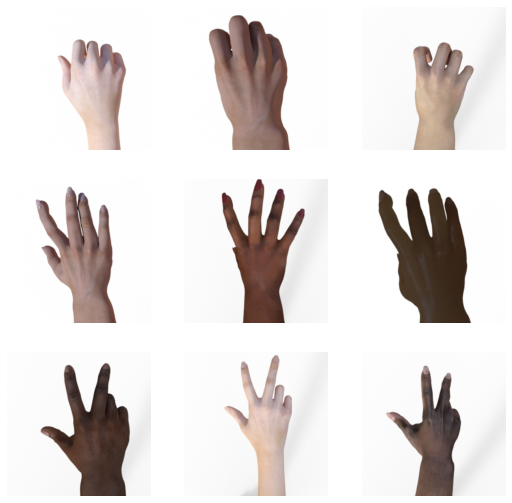

In [ ]:
# Plot some training images from the dataset
# Parameters for our graph; we'll output images in a 3x3 configuration
nrows = 3
ncols = 3

# Index for iterating over images
pic_index = 3

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

next_rock = [os.path.join(train_rock_dir, fname) 
                for fname in train_rock_files[pic_index-3:pic_index]]
next_paper = [os.path.join(train_paper_dir, fname) 
                for fname in train_paper_files[pic_index-3:pic_index]]
next_scissors = [os.path.join(train_scissors_dir, fname) 
                for fname in train_scissors_files[pic_index-3:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
	# Set up subplot; subplot indices start at 1
	sp = plt.subplot(nrows, ncols, i + 1)
	sp.axis('Off') # Don't show axes (or gridlines)
	img = mpimg.imread(img_path)
	plt.imshow(img)

plt.show()

In [ ]:
if (notifyStatus): status_notify("Task 2. Load and Prepare Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 3. Define and Train Model

In [ ]:
if (notifyStatus): status_notify("Task 3. Define and Train Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [ ]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == train_loss:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0, 1])
        plt.legend()

In [ ]:
# All images will be rescaled by 1./255
train_dir = "image/rps/"
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_dir = "image/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=default_image_size,  # All images will be resized to 300x300
        batch_size=default_batch,
        class_mode='categorical')

# Flow training images in batches using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,  # This is the source directory for training images
        target_size=default_image_size,  # All images will be resized to 300x300
        batch_size=default_batch,
        class_mode='categorical')

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [ ]:
# Define the baseline model for benchmarking
def create_nn_model(conv1_filters=64, conv2_filters=64, conv3_filters=128, conv4_filters=128,
                    conv1_dropout=0, conv2_dropout=0, conv3_dropout=0, conv4_dropout=0,
                    dense_nodes=512, dense_dropout=0, opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model = keras.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        # This is the first convolution
        keras.layers.Conv2D(conv1_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param, input_shape=(150, 150, 3)),
        # keras.layers.Dropout(conv1_dropout),
        keras.layers.MaxPooling2D(2,2),
        # This is the second convolution
        keras.layers.Conv2D(conv2_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        # keras.layers.Dropout(conv2_dropout),
        keras.layers.MaxPooling2D(2,2),
        # This is the third convolution
        keras.layers.Conv2D(conv3_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        # keras.layers.Dropout(conv3_dropout),
        keras.layers.MaxPooling2D(2,2),
        # This is the fourth convolution
        keras.layers.Conv2D(conv4_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        # keras.layers.Dropout(conv4_dropout),
        keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        keras.layers.Flatten(),
        # keras.layers.Dropout(dense_dropout),
        # 512 neuron hidden layer
        keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dense(num_class, activation='softmax', kernel_initializer=init_param)
    ])
    nn_model.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model

In [ ]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model = create_nn_model()
baseline_history = baseline_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
40/40 [==============================] - 19s 484ms/step - loss: 2.4357 - accuracy: 0.3433 - val_loss: 1.0976 - val_accuracy: 0.3333
Epoch 2/15
40/40 [==============================] - 19s 482ms/step - loss: 1.0283 - accuracy: 0.4794 - val_loss: 0.8471 - val_accuracy: 0.9059
Epoch 3/15
40/40 [==============================] - 19s 485ms/step - loss: 0.8895 - accuracy: 0.6067 - val_loss: 0.9303 - val_accuracy: 0.3898
Epoch 4/15
40/40 [==============================] - 19s 475ms/step - loss: 0.6423 - accuracy: 0.7409 - val_loss: 0.2619 - val_accuracy: 0.9382
Epoch 5/15
40/40 [==============================] - 19s 469ms/step - loss: 0.5198 - accuracy: 0.8044 - val_loss: 0.6670 - val_accuracy: 0.6935
Epoch 6/15
40/40 [==============================] - 19s 468ms/step - loss: 0.3337 - accuracy: 0.8806 - val_loss: 0.1045 - val_accuracy: 1.0000
Epoch 7/15
40/40 [==============================] - 19s 469ms/step - loss: 0.2800 - accuracy: 0.8921 - val_loss: 0.0968 - val_accuracy: 0.9812

In [ ]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       1

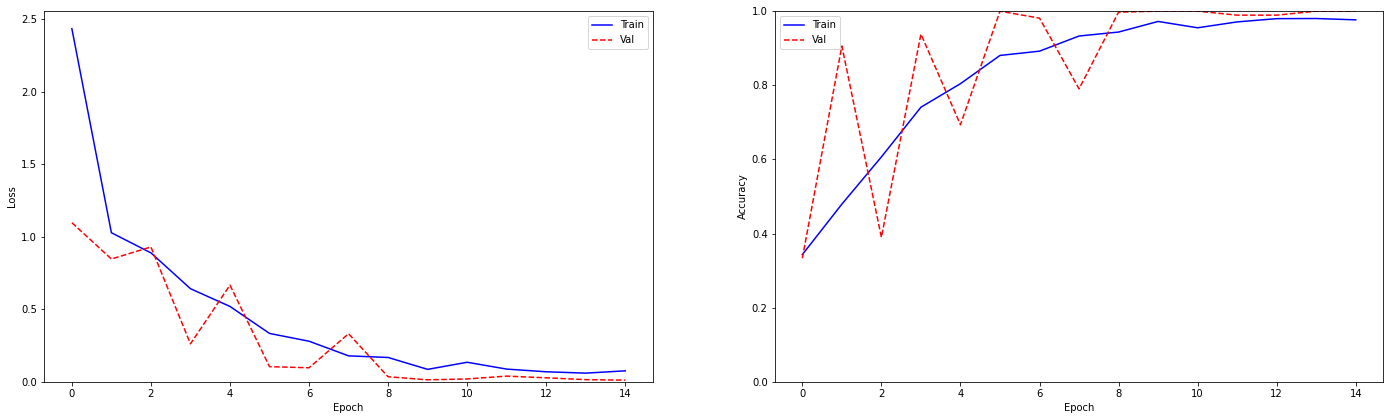

In [ ]:
plot_metrics(baseline_history)

In [ ]:
if (notifyStatus): status_notify("Task 3. Define and Train Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 4. Evaluate and Optimize Model

In [ ]:
if (notifyStatus): status_notify("Task 4. Evaluate and Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4.a) Experiment with Three VGG Blocks and One Convolution Layer Each Block

In [ ]:
# Define the baseline model for benchmarking
def create_model_4a(conv1_filters=64, conv2_filters=128, conv3_filters=256, conv4_filters=256,
                    conv1_dropout=0, conv2_dropout=0, conv3_dropout=0, conv4_dropout=0,
                    dense_nodes=512, dense_dropout=0, opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model_4a = keras.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        # This is the first convolution
        keras.layers.Conv2D(conv1_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param, input_shape=(150, 150, 3)),
        # keras.layers.Dropout(conv1_dropout),
        keras.layers.MaxPooling2D(2,2),
        # This is the second convolution
        keras.layers.Conv2D(conv2_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        # keras.layers.Dropout(conv2_dropout),
        keras.layers.MaxPooling2D(2,2),
        # This is the third convolution
        keras.layers.Conv2D(conv3_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        # keras.layers.Dropout(conv3_dropout),
        keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        keras.layers.Flatten(),
        # keras.layers.Dropout(dense_dropout),
        # 512 neuron hidden layer
        keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dense(num_class, activation='softmax', kernel_initializer=init_param)
    ])
    nn_model_4a.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model_4a

In [ ]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
reset_random(seedNum)
nn_model_4a = create_model_4a()
nn_model_4a_history = nn_model_4a.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
40/40 [==============================] - 19s 477ms/step - loss: 11.9572 - accuracy: 0.3770 - val_loss: 1.4015 - val_accuracy: 0.3333
Epoch 2/15
40/40 [==============================] - 19s 467ms/step - loss: 1.1401 - accuracy: 0.5143 - val_loss: 0.7689 - val_accuracy: 0.7554
Epoch 3/15
40/40 [==============================] - 19s 468ms/step - loss: 0.8865 - accuracy: 0.6306 - val_loss: 0.4456 - val_accuracy: 0.8763
Epoch 4/15
40/40 [==============================] - 19s 470ms/step - loss: 0.7181 - accuracy: 0.6897 - val_loss: 0.5311 - val_accuracy: 0.6667
Epoch 5/15
40/40 [==============================] - 19s 471ms/step - loss: 0.5977 - accuracy: 0.7806 - val_loss: 0.2201 - val_accuracy: 0.9355
Epoch 6/15
40/40 [==============================] - 19s 468ms/step - loss: 0.4348 - accuracy: 0.8623 - val_loss: 0.1852 - val_accuracy: 0.9355
Epoch 7/15
40/40 [==============================] - 19s 468ms/step - loss: 0.3305 - accuracy: 0.8655 - val_loss: 0.1282 - val_accuracy: 0.959

In [ ]:
nn_model_4a.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)            

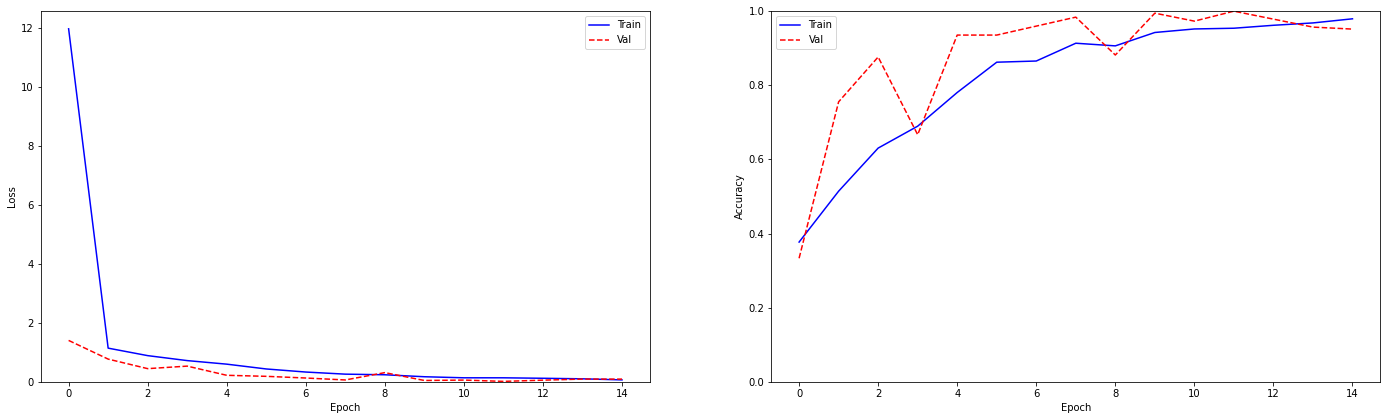

In [ ]:
plot_metrics(nn_model_4a_history)

## 4.b) Experiment with Three VGG Blocks and Two Convolution Layers Each Block

In [ ]:
# Define the baseline model for benchmarking
def create_model_4b(conv1_filters=64, conv2_filters=128, conv3_filters=256, conv4_filters=256,
                    conv1_dropout=0, conv2_dropout=0, conv3_dropout=0, conv4_dropout=0,
                    dense_nodes=512, dense_dropout=0, opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model_4b = keras.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        # This is the first convolution
        keras.layers.Conv2D(conv1_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param, input_shape=(150, 150, 3)),
        keras.layers.Conv2D(conv1_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        # keras.layers.Dropout(conv1_dropout),
        keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        # This is the second convolution
        keras.layers.Conv2D(conv2_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv2_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        # keras.layers.Dropout(conv2_dropout),
        keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        # This is the third convolution
        keras.layers.Conv2D(conv3_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv3_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        # keras.layers.Dropout(conv3_dropout),
        keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        # Flatten the results to feed into a DNN
        keras.layers.Flatten(),
        # keras.layers.Dropout(dense_dropout),
        # 512 neuron hidden layer
        keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dense(num_class, activation='softmax', kernel_initializer=init_param)
    ])
    nn_model_4b.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model_4b

In [ ]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
reset_random(seedNum)
nn_model_4b = create_model_4b()
nn_model_4b_history = nn_model_4b.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
40/40 [==============================] - 20s 509ms/step - loss: 29.8939 - accuracy: 0.3317 - val_loss: 1.3332 - val_accuracy: 0.3333
Epoch 2/15
40/40 [==============================] - 20s 501ms/step - loss: 1.1497 - accuracy: 0.3619 - val_loss: 1.2958 - val_accuracy: 0.4651
Epoch 3/15
40/40 [==============================] - 20s 500ms/step - loss: 1.1930 - accuracy: 0.3790 - val_loss: 1.0984 - val_accuracy: 0.3333
Epoch 4/15
40/40 [==============================] - 20s 498ms/step - loss: 1.3991 - accuracy: 0.4306 - val_loss: 3.5514 - val_accuracy: 0.3333
Epoch 5/15
40/40 [==============================] - 20s 499ms/step - loss: 1.0912 - accuracy: 0.5008 - val_loss: 0.7229 - val_accuracy: 0.7634
Epoch 6/15
40/40 [==============================] - 20s 503ms/step - loss: 0.9097 - accuracy: 0.5873 - val_loss: 0.4904 - val_accuracy: 0.8414
Epoch 7/15
40/40 [==============================] - 20s 499ms/step - loss: 0.7320 - accuracy: 0.7000 - val_loss: 0.6985 - val_accuracy: 0.647

In [ ]:
nn_model_4b.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 256)      

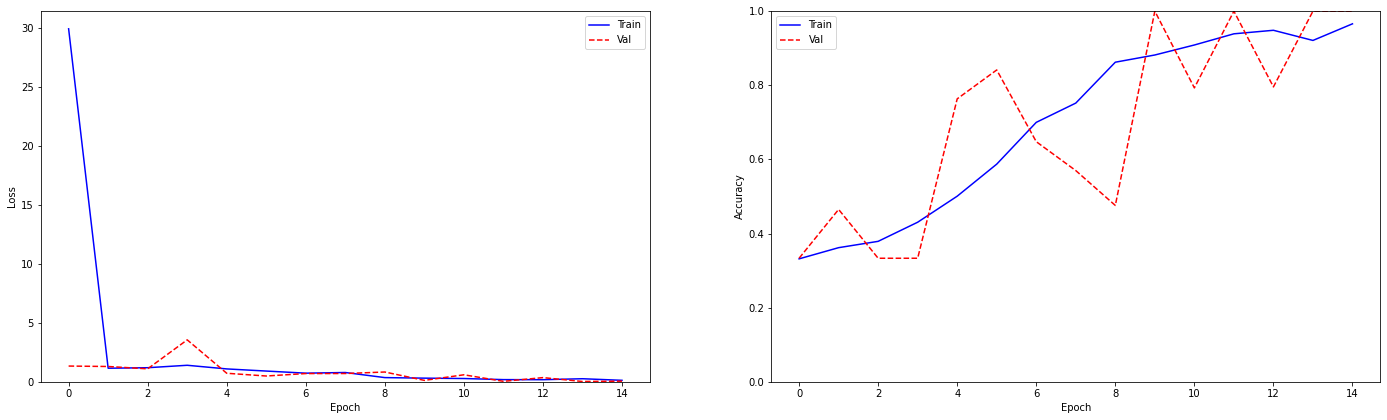

In [ ]:
plot_metrics(nn_model_4b_history)

## 4.c) Experiment with Three VGG Blocks and Three Convolution Layers Each Block

In [ ]:
# Define the baseline model for benchmarking
def create_model_4c(conv1_filters=64, conv2_filters=128, conv3_filters=256, conv4_filters=256,
                    conv1_dropout=0, conv2_dropout=0, conv3_dropout=0, conv4_dropout=0,
                    dense_nodes=512, dense_dropout=0, opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model_4c = keras.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        # This is the first convolution
        keras.layers.Conv2D(conv1_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param, input_shape=(150, 150, 3)),
        keras.layers.Conv2D(conv1_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv1_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        # keras.layers.Dropout(conv1_dropout),
        keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        # This is the second convolution
        keras.layers.Conv2D(conv2_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv2_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv2_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        # keras.layers.Dropout(conv2_dropout),
        keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        # This is the third convolution
        keras.layers.Conv2D(conv3_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv3_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv3_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        # keras.layers.Dropout(conv3_dropout),
        keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        # Flatten the results to feed into a DNN
        keras.layers.Flatten(),
        # keras.layers.Dropout(dense_dropout),
        # 512 neuron hidden layer
        keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dense(num_class, activation='softmax', kernel_initializer=init_param)
    ])
    nn_model_4c.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model_4c

In [ ]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
reset_random(seedNum)
nn_model_4c = create_model_4c()
nn_model_4c_history = nn_model_4c.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
40/40 [==============================] - 22s 556ms/step - loss: 81.4271 - accuracy: 0.3417 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 2/15
40/40 [==============================] - 22s 553ms/step - loss: 1.1981 - accuracy: 0.3413 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 3/15
40/40 [==============================] - 22s 549ms/step - loss: 1.1021 - accuracy: 0.3357 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/15
40/40 [==============================] - 22s 546ms/step - loss: 1.0988 - accuracy: 0.3135 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 5/15
40/40 [==============================] - 22s 547ms/step - loss: 1.0987 - accuracy: 0.3290 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 6/15
40/40 [==============================] - 22s 552ms/step - loss: 1.0988 - accuracy: 0.3242 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 7/15
40/40 [==============================] - 22s 546ms/step - loss: 1.0988 - accuracy: 0.3107 - val_loss: 1.0986 - val_accuracy: 0.333

In [ ]:
nn_model_4c.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 75, 75, 128)       147584    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 75, 75, 128)      

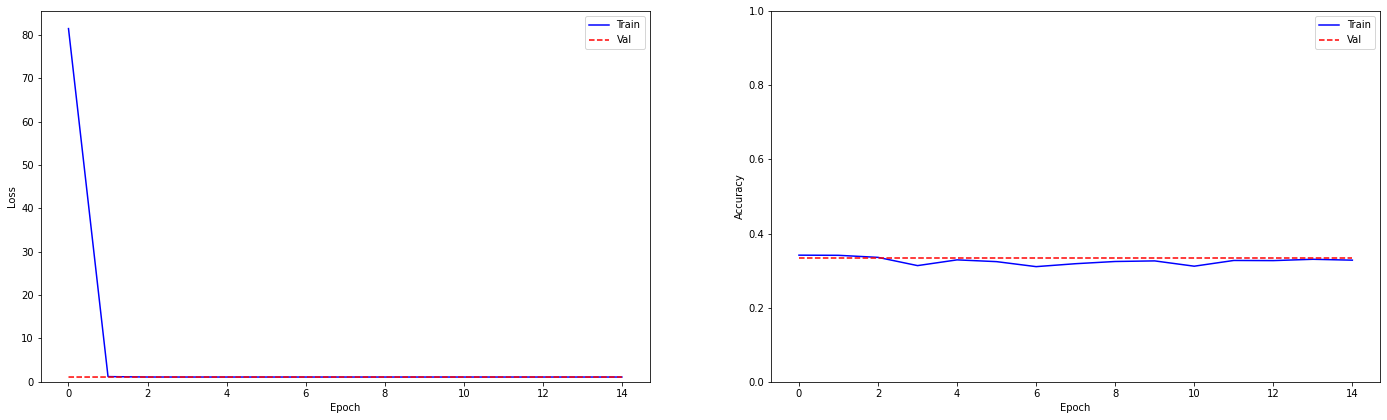

In [ ]:
plot_metrics(nn_model_4c_history)

In [ ]:
if (notifyStatus): status_notify("Task 4. Evaluate and Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 5. Finalize Model and Make Predictions

In [ ]:
if (notifyStatus): status_notify("Task 5. Finalize Model and Make Predictions has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [ ]:
final_model = nn_model_4a

# Display a summary of the final model
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)            

In [ ]:
if (notifyStatus): status_notify("Phase 5 Finalize Model and Make Predictions completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [ ]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:21:06.101114
